In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from typing import Callable
from scipy.sparse import hstack
from itertools import product
import random

from sales_forecasting.utils import timeseries_split, build_submission_df
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
df_unfiltered = pd.read_parquet(".data/data.parquet")

In [5]:
# Filter redundant columns
cols = ['date_block_num', 'shop_id', 'city_id', 'item_id', 'item_category_id', 'general_item_category_id', 'item_price', 'date_month', 'item_cnt_day']
df = df_unfiltered[cols]

In [6]:
# Filter outliers
shp = df.shape[0]
outliers_item_price_index = df['item_price'] > 100000
outliers_item_cnt_day_index = df['item_cnt_day'] > 1000

display(df[outliers_item_price_index])
display(df[outliers_item_cnt_day_index])

df = df.drop(df[outliers_item_price_index].index)
df = df.drop(df[outliers_item_cnt_day_index].index)
print(f"Filtered {shp - df.shape[0]} outliers")

,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
325725,11,12,8,6066,75,15,307980.0,11,1.0


,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
334422,33,12,8,11373,9,3,0.908714,9,2169.0


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_96547/4117026004.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df[outliers_item_cnt_day_index].index)


Filtered 2 outliers


In [7]:
# Imput missing/wrong values
missing_item_price_index = df['item_price'] <= 0
mean_imputation = df[(df.shop_id == 32) & (df.item_id == 2973) & (df.date_block_num == 4) & (df.item_price > 0)]['item_price'].mean()
df.loc[missing_item_price_index, 'item_price'] = mean_imputation
display(df[missing_item_price_index])

,date_block_num,shop_id,city_id,item_id,item_category_id,general_item_category_id,item_price,date_month,item_cnt_day
1645106,4,32,14,2973,19,5,1874.0,4,1.0


In [8]:
# Filter repeating shops
repeating_shops_pairs =  [(0, 57), (1, 58), (10, 11)]

for orig, rep in repeating_shops_pairs:
    display(df_unfiltered[df_unfiltered.shop_id.isin([rep, orig])][['shop_id', 'shop_name_en', 'city']].drop_duplicates())
    df.loc[df.shop_id == rep, 'shop_id'] = orig

,shop_id,shop_name_en,city
0,0,"Yakutsk Ordzhonikidze, 56 Franchise",Yakutsk
2704872,57,"Yakutsk Ordzhonikidze, 56",Yakutsk


,shop_id,shop_name_en,city
9857,1,Yakutsk Central Mall Franchise,Yakutsk
2822300,58,Yakutsk Central Mall,Yakutsk


,shop_id,shop_name_en,city
291381,10,Zhukovsky Chkalov St 39m?,Zhukovsky
312778,11,Zhukovsky Chkalov St 39m²,Zhukovsky


In [9]:
# Aggregate data monthly (sum daily sales)
base_cols = ['date_block_num', 'shop_id', 'item_id']
cols = base_cols + ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']

df_agg_monthly = df.copy()
df_agg_monthly['item_cnt_day'] = df['item_cnt_day'].fillna(0)
df_agg_monthly = df_agg_monthly \
    .groupby(base_cols).agg({"item_cnt_day": "sum"}) \
    .reset_index() \
    .rename(columns={"item_cnt_day": "item_cnt_month"})
df_agg_monthly = df_agg_monthly.merge(df[cols].drop_duplicates(), on=base_cols, how='left')

In [10]:
# Oversample for month x shop x item where item_cnt_month == 0 (only train data, as test data already covers such combinations)
# matrix = []
# cols = ['date_block_num','shop_id','item_id']
# for i in range(34):
#     df_train_month = df[df.date_block_num==i]
#     matrix.append(np.array(list(product([i], df_train_month.shop_id.unique(), df_train_month.item_id.unique()))))

matrix, shops_cache, items_cache = [], np.array([]), np.array([])
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    df_train_month = df[df.date_block_num==i]
    shops_cache = np.union1d(shops_cache, df_train_month.shop_id.unique())
    items_cache = np.union1d(items_cache, df_train_month.item_id.unique())
    matrix.append(np.array(list(product([i], shops_cache, items_cache))))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix = pd.concat([matrix, df[df.date_block_num==34][cols]], ignore_index=True, sort=False)
matrix = matrix.sort_values(cols).reset_index(drop=True)

df_agg_monthly_oversampled = pd.merge(matrix, df_agg_monthly[cols + ['item_cnt_month']], on=cols, how='left').fillna(0)
df_agg_monthly_oversampled = df_agg_monthly_oversampled \
    .merge(df[['shop_id', 'city_id']].drop_duplicates(), on='shop_id', how='left') \
    .merge(df[['item_id', 'item_category_id', 'general_item_category_id']].drop_duplicates(), on='item_id', how='left') \
    .merge(df[['date_block_num', 'date_month']].drop_duplicates(), on='date_block_num', how='left')

In [11]:
df_agg_monthly_oversampled

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month
0,0.0,0.0,19.0,0.0,0,40,11,0
1,0.0,0.0,27.0,0.0,0,19,5,0
2,0.0,0.0,28.0,0.0,0,30,8,0
3,0.0,0.0,29.0,0.0,0,23,5,0
4,0.0,0.0,32.0,6.0,0,40,11,0
...,...,...,...,...,...,...,...,...
29460949,34.0,59.0,22162.0,0.0,30,40,11,10
29460950,34.0,59.0,22163.0,0.0,30,40,11,10
29460951,34.0,59.0,22164.0,0.0,30,37,11,10
29460952,34.0,59.0,22166.0,0.0,30,54,12,10


In [12]:
df_agg_monthly_oversampled[(df_agg_monthly_oversampled.shop_id == 2) & (df_agg_monthly_oversampled.item_id.isin([30, 31, 32]))].groupby(["shop_id", "item_id"]).apply(display)

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month
383884,1.0,2.0,30.0,0.0,1,40,11,1
815672,2.0,2.0,30.0,1.0,1,40,11,2
1283828,3.0,2.0,30.0,0.0,1,40,11,3
1780980,4.0,2.0,30.0,0.0,1,40,11,4
2320662,5.0,2.0,30.0,1.0,1,40,11,5
2897124,6.0,2.0,30.0,0.0,1,40,11,6
3495088,7.0,2.0,30.0,0.0,1,40,11,7
4115440,8.0,2.0,30.0,0.0,1,40,11,8
4754764,9.0,2.0,30.0,0.0,1,40,11,9
5439096,10.0,2.0,30.0,0.0,1,40,11,10


,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month
383885,1.0,2.0,31.0,4.0,1,37,11,1
815673,2.0,2.0,31.0,1.0,1,37,11,2
1283829,3.0,2.0,31.0,1.0,1,37,11,3
1780981,4.0,2.0,31.0,0.0,1,37,11,4
2320663,5.0,2.0,31.0,0.0,1,37,11,5
2897125,6.0,2.0,31.0,0.0,1,37,11,6
3495089,7.0,2.0,31.0,0.0,1,37,11,7
4115441,8.0,2.0,31.0,0.0,1,37,11,8
4754765,9.0,2.0,31.0,0.0,1,37,11,9
5439097,10.0,2.0,31.0,0.0,1,37,11,10


,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month
16234,0.0,2.0,32.0,0.0,1,40,11,0
383886,1.0,2.0,32.0,0.0,1,40,11,1
815674,2.0,2.0,32.0,0.0,1,40,11,2
1283830,3.0,2.0,32.0,0.0,1,40,11,3
1780982,4.0,2.0,32.0,0.0,1,40,11,4
2320664,5.0,2.0,32.0,0.0,1,40,11,5
2897126,6.0,2.0,32.0,0.0,1,40,11,6
3495090,7.0,2.0,32.0,0.0,1,40,11,7
4115442,8.0,2.0,32.0,0.0,1,40,11,8
4754766,9.0,2.0,32.0,0.0,1,40,11,9


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_96547/4122066322.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg_monthly_oversampled[(df_agg_monthly_oversampled.shop_id == 2) & (df_agg_monthly_oversampled.item_id.isin([30, 31, 32]))].groupby(["shop_id", "item_id"]).apply(display)


""


In [ ]:
def merge_with_oversampled_index(df: pd.DataFrame, oversampled_index: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()

    return pd.merge(df_features, oversampled_index.reset_index(), on=["shop_id", "item_id", "date_block_num"], how='outer', suffixes=(None, '_y'), indicator=True)

def build_month_features(df: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()

    df_features['month_sin'] = np.sin(np.pi / 12 * df['date_month'])
    df_features['month_cos'] = np.cos(np.pi / 12 * df['date_month'])
    
    return df_features

def build_lagged_features(df: pd.DataFrame, lags: list[int]) -> pd.DataFrame:
    df_features = df.copy()

    lagged_features = col_name("lagged", lags)

    df_features = df_features.sort_values(["shop_id", "item_id", "date_block_num"])
    for feat, lag in zip(lagged_features, lags):
        df_features[feat] = df_features.groupby(["shop_id", "item_id"])['item_cnt_month'].shift(lag).bfill()#.fillna(0)
    
    return df_features

def build_rolling_features(df: pd.DataFrame, rolling: list[int]) -> pd.DataFrame:
    df_features = df.copy()
    
    assert "lagged_1" in df_features.columns, "lagged_1 column must be present in the dataframe to create roll for past months"
    rolling_features = col_name("rolling", rolling)

    df_features = df_features.sort_values(["shop_id", "item_id", "date_block_num"])
    for feat, roll in zip(rolling_features, rolling):
        df_features[feat] = df_features.groupby(["shop_id", "item_id"])['lagged_1'].rolling(roll).mean().bfill().reset_index(level=[0,1], drop=True)

    return df_features

def drop_merged(df: pd.DataFrame) -> pd.DataFrame:
    df_features = df.copy()
    
    df_features = df_features.drop(df_features[df_features['_merge'] == "right_only"].index)
    df_features = df_features.drop(columns=['_merge', 'item_cnt_month_y'])
    return df_features

def build_features(df: pd.DataFrame, lagged_features: list[int], rolling_features: list[int]) -> pd.DataFrame:
    df_featurized = df \
        .pipe(build_month_features) \
        .pipe(build_lagged_features, lags=lagged_features) \
        .pipe(build_rolling_features, rolling=rolling_features)
    
    assert df_featurized.shape[0] == df.shape[0]
    
    return df_featurized

In [14]:
lagged_features = list(range(1, 12))
rolling_features = [3, 6, 9]

cols =  {
    'cat': ['shop_id', 'item_category_id', 'general_item_category_id', 'city_id',],
    'num': ['month_sin', 'month_cos'] + col_name("lagged", lagged_features) + col_name("rolling", rolling_features), #+ col_name("item_name_tfidf", list(range(0, 1000))),
    'target': "item_cnt_month"
}

In [15]:
df_agg_monthly_oversampled = build_features(df_agg_monthly_oversampled, lagged_features, rolling_features)

In [16]:
def aggregate_historical_features_and_merge(
    df_monthly: pd.DataFrame,
    df_daily: pd.DataFrame,  
    index_cols: list[str],
    agg_col: str
) -> pd.DataFrame:
    cross_cols = index_cols[1:] # drop date_block_num
    new_column_name = f"avg_{'_'.join([x.split('_id')[0] for x in cross_cols])}_{agg_col}"

    avg_index = df_daily.groupby(index_cols).agg({agg_col: "mean"}).reset_index().rename(columns={agg_col: new_column_name})
    avg_index[f'{new_column_name}_lag_1'] = avg_index.groupby(cross_cols)[new_column_name].shift(1).bfill()
    avg_index = avg_index.drop(columns=[new_column_name])

    return df_monthly.merge(avg_index, on=index_cols, how='left').ffill()

In [17]:
df_agg_monthly_oversampled = df_agg_monthly_oversampled \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_category_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'shop_id', 'item_category_id'], agg_col='item_cnt_day') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_category_id'], agg_col='item_price') \
    .pipe(aggregate_historical_features_and_merge, df_daily=df, index_cols=['date_block_num', 'item_category_id'], agg_col='item_cnt_day')

In [18]:
df_agg_monthly_oversampled

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,rolling_6,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1
0,20.0,0.0,0.0,0.0,0,40,11,8,0.866025,-5.000000e-01,...,0.0,0.0,NaN,NaN,4490.0,1.000000,270.396570,1.162915,264.090060,1.080522
1,21.0,0.0,0.0,0.0,0,40,11,9,0.707107,-7.071068e-01,...,0.0,0.0,NaN,NaN,4490.0,1.000000,263.607092,1.149903,265.388479,1.079698
2,22.0,0.0,0.0,0.0,0,40,11,10,0.500000,-8.660254e-01,...,0.0,0.0,NaN,NaN,4490.0,1.000000,263.767150,1.170784,263.751745,1.088073
3,23.0,0.0,0.0,0.0,0,40,11,11,0.258819,-9.659258e-01,...,0.0,0.0,NaN,NaN,4490.0,1.000000,262.253676,1.138378,264.032958,1.090300
4,24.0,0.0,0.0,0.0,0,40,11,0,0.000000,1.000000e+00,...,0.0,0.0,NaN,NaN,4490.0,1.000000,262.391258,1.228041,261.918712,1.132266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460949,29.0,59.0,22169.0,0.0,30,69,14,5,0.965926,2.588190e-01,...,0.0,0.0,299.0,1.0,169.0,1.068966,489.000000,1.000000,1130.063011,1.031097
29460950,30.0,59.0,22169.0,0.0,30,69,14,6,1.000000,6.123234e-17,...,0.0,0.0,299.0,1.0,169.0,1.068966,1079.625000,1.125000,938.685683,1.047619
29460951,31.0,59.0,22169.0,0.0,30,69,14,7,0.965926,-2.588190e-01,...,0.0,0.0,299.0,1.0,169.0,1.068966,552.879394,1.151515,738.698594,1.071497
29460952,32.0,59.0,22169.0,0.0,30,69,14,8,0.866025,-5.000000e-01,...,0.0,0.0,299.0,1.0,169.0,1.068966,822.500000,1.000000,888.368037,1.034443


In [19]:
def compute_months_since_last_buy(x):
    count = -1
    months_since_last_buy = []
    for i in x:
        count += 1
        months_since_last_buy.append(count)

        if i > 0:
            count = -1  # Reset counter if there's a sale
    return months_since_last_buy

mslb = df_agg_monthly_oversampled \
    .groupby(["shop_id", "item_id"])['item_cnt_month'] \
    .apply(compute_months_since_last_buy) \
    .reset_index() \
    .rename(columns={"item_cnt_month": "months_since_last_buy"}) \
    .explode("months_since_last_buy")
df_agg_monthly_oversampled['months_since_last_buy'] = mslb['months_since_last_buy'].values

In [20]:
# Filter data (shop x item) where date_block_num < 12
df_agg_monthly_oversampled = df_agg_monthly_oversampled[df_agg_monthly_oversampled.date_block_num >= 12]

In [21]:
df_agg_monthly_oversampled[df_agg_monthly_oversampled.avg_shop_item_item_price_lag_1.isna()]

,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy
0,20.0,0.0,0.0,0.0,0,40,11,8,0.866025,-5.000000e-01,...,0.0,NaN,NaN,4490.0,1.0,270.396570,1.162915,264.090060,1.080522,0
1,21.0,0.0,0.0,0.0,0,40,11,9,0.707107,-7.071068e-01,...,0.0,NaN,NaN,4490.0,1.0,263.607092,1.149903,265.388479,1.079698,1
2,22.0,0.0,0.0,0.0,0,40,11,10,0.500000,-8.660254e-01,...,0.0,NaN,NaN,4490.0,1.0,263.767150,1.170784,263.751745,1.088073,2
3,23.0,0.0,0.0,0.0,0,40,11,11,0.258819,-9.659258e-01,...,0.0,NaN,NaN,4490.0,1.0,262.253676,1.138378,264.032958,1.090300,3
4,24.0,0.0,0.0,0.0,0,40,11,0,0.000000,1.000000e+00,...,0.0,NaN,NaN,4490.0,1.0,262.391258,1.228041,261.918712,1.132266,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,29.0,0.0,29.0,0.0,0,23,5,5,0.965926,2.588190e-01,...,0.0,NaN,NaN,1398.0,1.0,1505.414623,1.041096,1446.451710,1.038882,29
493,30.0,0.0,29.0,0.0,0,23,5,6,1.000000,6.123234e-17,...,0.0,NaN,NaN,1398.0,1.0,1291.039683,1.000000,1247.414183,1.044452,30
494,31.0,0.0,29.0,0.0,0,23,5,7,0.965926,-2.588190e-01,...,0.0,NaN,NaN,1398.0,1.0,1406.601695,1.042373,1383.274653,1.047059,31
495,32.0,0.0,29.0,0.0,0,23,5,8,0.866025,-5.000000e-01,...,0.0,NaN,NaN,1398.0,1.0,1252.441923,1.029586,1164.672498,1.093142,32


In [22]:
df_agg_monthly_oversampled = df_agg_monthly_oversampled.bfill()

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_96547/1916837525.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_agg_monthly_oversampled = df_agg_monthly_oversampled.bfill()


In [23]:
df_agg_monthly_oversampled.dtypes

date_block_num                               float64
shop_id                                      float64
item_id                                      float64
item_cnt_month                               float64
city_id                                        int64
item_category_id                               int64
general_item_category_id                       int64
date_month                                     int64
month_sin                                    float64
month_cos                                    float64
lagged_1                                     float64
lagged_2                                     float64
lagged_3                                     float64
lagged_4                                     float64
lagged_5                                     float64
lagged_6                                     float64
lagged_7                                     float64
lagged_8                                     float64
lagged_9                                     f

In [24]:
# Set dtypes
dtypes = {
    'date_block_num': 'uint8',
    'shop_id': 'uint8',
    'city_id': 'uint8',
    'item_id': 'uint16',
    'item_category_id': 'uint8',
    'general_item_category_id': 'uint8',
    'date_month': 'uint8',
    'item_cnt_month': 'int32',
    'month_sin': 'float16',
    'month_cos': 'float16',
    **{f'lagged_{i}': 'int16' for i in lagged_features},
    **{f'rolling_{i}': 'float16' for i in rolling_features},
    "avg_shop_item_item_price_lag_1": "float16",
    "avg_shop_item_item_cnt_day_lag_1": "float16",
    "avg_item_item_price_lag_1": "float16",
    "avg_item_item_cnt_day_lag_1": "float16",
    "avg_shop_item_category_item_price_lag_1": "float16",
    "avg_shop_item_category_item_cnt_day_lag_1": "float16",
    "avg_item_category_item_price_lag_1": "float16",
    "avg_item_category_item_cnt_day_lag_1": "float16",
    "months_since_last_buy": "uint8"
}

for column, dtype in dtypes.items():
    df_agg_monthly_oversampled[column] = df_agg_monthly_oversampled[column].astype(dtype) # type: ignore

print(df_agg_monthly_oversampled.dtypes)

date_block_num                                 uint8
shop_id                                        uint8
item_id                                       uint16
item_cnt_month                                 int32
city_id                                        uint8
item_category_id                               uint8
general_item_category_id                       uint8
date_month                                     uint8
month_sin                                    float16
month_cos                                    float16
lagged_1                                       int16
lagged_2                                       int16
lagged_3                                       int16
lagged_4                                       int16
lagged_5                                       int16
lagged_6                                       int16
lagged_7                                       int16
lagged_8                                       int16
lagged_9                                      

In [39]:
df_agg_monthly_oversampled.to_parquet(".data/df_agg_monthly_oversampled.parquet")

In [25]:
train_split, valid_split = timeseries_split(df_agg_monthly_oversampled, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df_agg_monthly_oversampled, max_month=34, col='date_block_num', continuous=False)

In [26]:
target_col = cols['target']
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [27]:
train_split.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_id',
       'item_category_id', 'general_item_category_id', 'date_month',
       'month_sin', 'month_cos', 'lagged_1', 'lagged_2', 'lagged_3',
       'lagged_4', 'lagged_5', 'lagged_6', 'lagged_7', 'lagged_8', 'lagged_9',
       'lagged_10', 'lagged_11', 'rolling_3', 'rolling_6', 'rolling_9',
       'avg_shop_item_item_price_lag_1', 'avg_shop_item_item_cnt_day_lag_1',
       'avg_item_item_price_lag_1', 'avg_item_item_cnt_day_lag_1',
       'avg_shop_item_category_item_price_lag_1',
       'avg_shop_item_category_item_cnt_day_lag_1',
       'avg_item_category_item_price_lag_1',
       'avg_item_category_item_cnt_day_lag_1', 'months_since_last_buy'],
      dtype='object')

In [28]:
cols_to_drop = [target_col, 'date_block_num', 'shop_id', 'item_id']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

In [37]:
params = {
    'num_leaves': 70,
    'max_depth': 10,
    'learning_rate': 0.067834647652625,
    'n_estimators': 50,
    'reg_alpha': 9.337066364872312,
    'reg_lambda': 1.949581652106863,
    'colsample_bytree': 0.5,
    'subsample': 0.4, 
    'min_child_samples': 160, 
    'min_data_per_groups': 49
}
model = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
model.fit(X_train, train_target, eval_set=[(X_valid, valid_target)])

y_pred = model.predict(X_valid)
rmse = metrics.root_mean_squared_error(valid_target.values, y_pred)
print("LGBM model Valid RMSE: ", rmse)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.371585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 21137776, number of used features: 29
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
LGBM model Valid RMSE:  0.3986348604888272


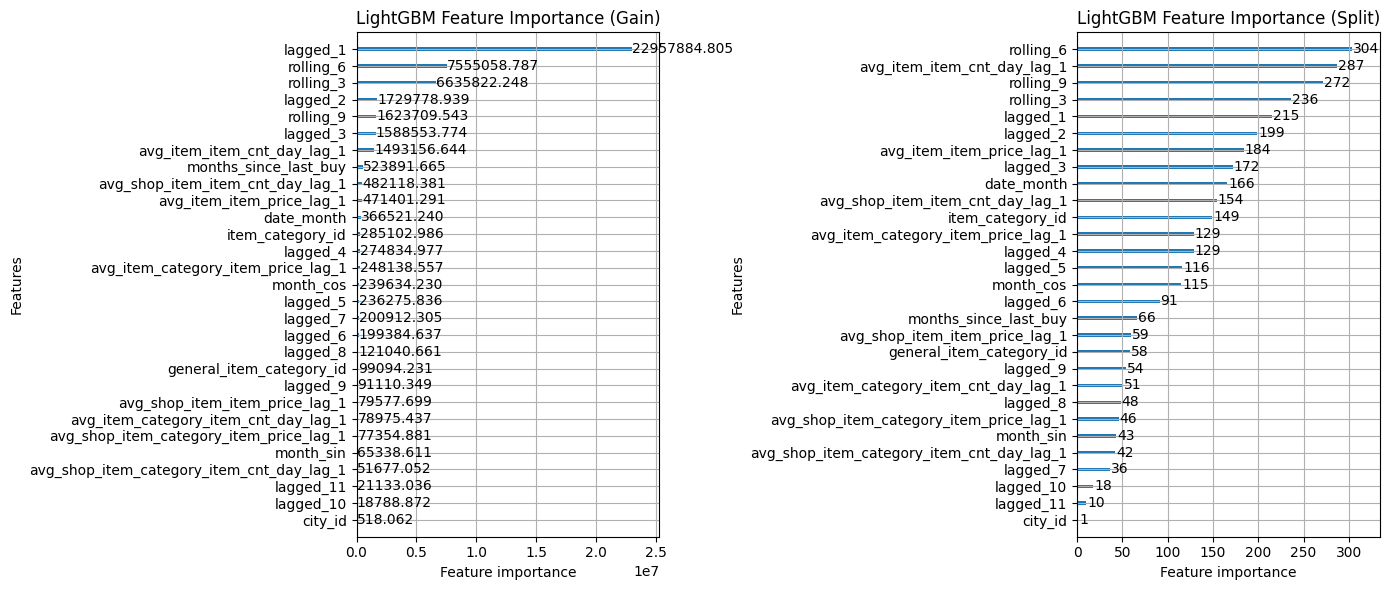

In [38]:
plot_feature_importance(model)

In [ ]:
import optuna

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**param, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
    model.fit(X_train, train_target, eval_set=[(X_valid, valid_target)])

    y_valid_pred = model.predict(X_valid)
    rmse = metrics.root_mean_squared_error(valid_target, y_valid_pred)
    return rmse

# Create a study and optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

In [ ]:
# Revert repeating shops
test_split = pd.concat([
    test_split,
    test_split[test_split.shop_id == 0].assign(shop_id=57), 
    test_split[test_split.shop_id == 1].assign(shop_id=58),
    test_split[test_split.shop_id == 10].assign(shop_id=11),])

In [ ]:
X_train_test, X_test = train_test_split.drop(columns=cols_to_drop), test_split.drop(columns=cols_to_drop)
train_test_target = train_test_split[target_col].clip(0, 20)

model_submission = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
model_submission.fit(X_train_test, train_test_target)

y_test_pred = model_submission.predict(X_test)
evaluation_dataset = test_split[['shop_id', 'item_id']]
evaluation_dataset = evaluation_dataset.assign(item_cnt_month=y_test_pred.clip(0, 20))
build_submission_df(evaluation_dataset, save_path=".data/submissions/submission_xgb6.csv")


In [ ]:
y_train_test_pred = model_submission.predict(X_train_test)
train_test_split_pred = train_test_split.assign(pred=y_train_test_pred)

In [ ]:
train_test_split_pred

In [ ]:
plot_timeseries(train_test_split_pred, plt_rows=30, plt_cols=2, rand=True, pred_col='pred')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

def train_sklearn_model(df, model, cols):
    ohe_cols = cols['cat']
    ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
    ohe.fit(df[ohe_cols])

    train_split, test_split = timeseries_split(df, 33, col='date_block_num', continuous=False)

    X_train_cat = ohe.transform(train_split[ohe_cols])
    X_test_cat = ohe.transform(test_split[ohe_cols])

    num_cols = cols['num']
    X_train_num = train_split[num_cols]
    X_test_num = test_split[num_cols]

    X_train = hstack([X_train_cat, X_train_num]).tocsr()
    X_test = hstack([X_test_cat, X_test_num]).tocsr()

    y_train = train_split['item_cnt_month_clipped']
    y_test = test_split['item_cnt_month_clipped']

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    train_rmse = metrics.root_mean_squared_error(y_train, y_pred_train)
    y_pred_test = model.predict(X_test)
    test_rmse = metrics.root_mean_squared_error(y_test, y_pred_test)
    print(f'Train RMSE: {train_rmse} \nTest RMSE: {test_rmse}')

    return model

feature_columns = {
    'cat': ['shop_id', 'item_category_id'],
    'num': ['month_sin', 'month_cos'] + [f'lagged_{_}' for _ in range(1,8)] + [f'rolling_{_}' for _ in (3, 6, 12, 24)]
}

In [ ]:
linear_model = train_sklearn_model(df, model=LinearRegression(), cols=feature_columns)

In [ ]:
nn_model = train_sklearn_model(df, model=MLPRegressor(max_iter=100, hidden_layer_sizes=[256, ], verbose=True), cols=feature_columns)